In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree
from pathlib import Path

#pd.set_option("display.max_rows", 10)

In [358]:
# define each participant's role 
participants = {'D1_1/ID_1': {'team': 2, 'role': 1}, 'D1_1/ID_2': {'team': 2, 'role': 0}, 'D1_1/ID_3': {'team': 1, 'role': 0},
            'D1_1/ID_4': {'team': 3, 'role': 1},'D1_1/ID_5': {'team': 3, 'role': 0},'D1_1/ID_6': {'team': 4, 'role': 0},
            'D1_1/ID_7': {'team': 4, 'role': 1},'D1_1/ID_8': {'team': 1, 'role': 1},'D1_2/ID_1': {'team': 1, 'role': 0},
            'D1_2/ID_2': {'team': 2, 'role': 0},'D1_2/ID_3': {'team': 3, 'role': 0},'D1_2/ID_4': {'team': 3, 'role': 1},
            'D1_2/ID_5': {'team': 1, 'role': 1},'D1_2/ID_6': {'team': 2, 'role': 1},'D1_3/D1_3_1/ID_1': {'team': 8, 'role': 1},
            'D1_3/D1_3_1/ID_2': {'team': 9, 'role': 1},'D1_3/D1_3_1/ID_3': {'team': 8, 'role': 0},'D1_3/D1_3_1/ID_4': {'team': 9, 'role': 0},
            'D1_3/D1_3_2/ID_1': {'team': 10, 'role': 1},'D1_3/D1_3_2/ID_2': {'team': 11, 'role': 0},'D1_3/D1_3_2/ID_3': {'team': 10, 'role': 0},
            'D1_3/D1_3_2/ID_4': {'team': 11, 'role': 1},'D1_3/D1_3_3/ID_1': {'team': 12, 'role': 0},'D1_3/D1_3_3/ID_2': {'team': 12, 'role': 1},
            'D1_3/D1_3_4/ID_1': {'team': 13, 'role': 0},'D1_3/D1_3_4/ID_2': {'team': 13, 'role': 1}}

In [359]:
phase_list = ['phase1', 'phase2', 'phase3']
features = ['BVP', 'EDA', 'HR', 'TEMP']
df_dict = {}
roles = []
for feature in features:
    df_dict[feature] = {}
    for phase in phase_list:
        df = pd.DataFrame()
        for i, participant in enumerate(participants):
            data = pd.read_csv(f'dataset_teams/{participant}/round_1/{phase}/{feature}.csv')
            data.drop(data.columns[[0,2]], axis=1, inplace=True)
            data_list = data[feature].tolist()
            column_name = f'{feature}_{i+1}'
            df[column_name] = pd.Series(data_list)
            df.dropna(inplace=True)
            roles.append(participants[participant]['role'])
        df_dict[feature][phase] = df

In [360]:
for feature in features:
    for phase in phase_list:
        print(f'{feature} - {phase} - max')
        print(df_dict[feature][phase].max().max())
        print(f'{feature} - {phase} - min')
        print(df_dict[feature][phase].min().min())

BVP - phase1 - max
1250.95
BVP - phase1 - min
-1476.37
BVP - phase2 - max
1043.4
BVP - phase2 - min
-979.1
BVP - phase3 - max
1650.04
BVP - phase3 - min
-1629.35
EDA - phase1 - max
28.905752
EDA - phase1 - min
0.101213
EDA - phase2 - max
42.50436
EDA - phase2 - min
0.117868
EDA - phase3 - max
46.435299
EDA - phase3 - min
0.124274
HR - phase1 - max
150.36
HR - phase1 - min
53.28
HR - phase2 - max
137.67
HR - phase2 - min
54.48
HR - phase3 - max
157.97
HR - phase3 - min
58.97
TEMP - phase1 - max
35.21
TEMP - phase1 - min
29.53
TEMP - phase2 - max
35.33
TEMP - phase2 - min
29.37
TEMP - phase3 - max
35.79
TEMP - phase3 - min
29.19


## Phase 1

In [361]:
#Creating df's for each TEMP, BVP.....
dt_temp_phase1 = df_dict['TEMP']['phase1'].T
dt_BVP_phase1 = df_dict['BVP']['phase1'].T
dt_EDA_phase1 = df_dict['EDA']['phase1'].T
dt_HR_phase1 = df_dict['HR']['phase1'].T

In [362]:
df_all = [dt_temp_phase1.shape[1],dt_BVP_phase1.shape[1],dt_EDA_phase1.shape[1],dt_HR_phase1.shape[1]]

In [363]:
minvalue = df_all[0]
minindex=np.inf
for index, value in enumerate(df_all):
    if value < minvalue:
        minvalue=value
        minindex=index

print(minvalue,minindex)

229 3


In [364]:
fir_order = 0 # This determines the cutoff frequency of the filter!!!! min value of each hour at least
downsampling_factor_temp_phase1 = int(np.round(dt_temp_phase1.shape[1]/minvalue))
downsampling_factor_BVP_phase1 = int(np.round(dt_BVP_phase1.shape[1]/minvalue))
downsampling_factor_EDA_phase1 = int(np.round(dt_EDA_phase1.shape[1]/minvalue))
#########
resampled_temp_phase1  = scipy.signal.decimate(dt_temp_phase1 , downsampling_factor_temp_phase1 , ftype='fir', zero_phase=True, n=fir_order)
resampled_BVP_phase1  = scipy.signal.decimate(dt_BVP_phase1 , downsampling_factor_BVP_phase1 , ftype='fir', zero_phase=True, n=fir_order)
resampled_EDA_phase1  = scipy.signal.decimate(dt_EDA_phase1 , downsampling_factor_EDA_phase1 , ftype='fir', zero_phase=True, n=fir_order)

## Merging together the attributes

In [365]:
temp_phase1_flat = resampled_temp_phase1.flatten()
BVP_phase1_flat = resampled_BVP_phase1.flatten()
EDA_phase1_flat = resampled_EDA_phase1.flatten()
HR_phase1_flat = dt_HR_phase1.to_numpy().flatten()

In [366]:
df_all_flat = np.vstack([temp_phase1_flat, BVP_phase1_flat, EDA_phase1_flat, HR_phase1_flat])
df_all_flat

array([[ 3.097000e+01,  3.101000e+01,  3.097000e+01, ...,  3.384000e+01,
         3.384000e+01,  3.383000e+01],
       [-6.133000e+01,  7.742900e+02,  5.939000e+01, ...,  9.420000e+01,
        -2.520000e+01,  4.100000e+01],
       [ 1.858270e-01,  1.858270e-01,  1.819820e-01, ...,  4.748411e+00,
         4.735600e+00,  4.724069e+00],
       [ 7.675000e+01,  7.675000e+01,  7.673000e+01, ...,  8.993000e+01,
         8.993000e+01,  8.998000e+01]])

In [367]:
dt = pd.DataFrame(df_all_flat.T, columns=['temp','BVP','EDA','HR'])

In [368]:
dt = (dt-dt.mean()) / dt.std()
dt

,temp,BVP,EDA,HR
0,-1.061050,-0.719850,-0.655462,-0.212864
1,-1.034987,9.294355,-0.655462,-0.212864
2,-1.061050,0.726878,-0.656000,-0.214694
3,-1.048018,0.679061,-0.655821,-0.215608
4,-1.061050,0.111012,-0.656000,-0.215608
...,...,...,...,...
5949,0.809000,-0.046340,-0.012992,0.991757
5950,0.809000,0.233610,-0.015860,0.991757
5951,0.809000,1.144047,-0.017115,0.992672
5952,0.809000,-0.286862,-0.018907,0.992672


## Apply Pca

In [369]:
from sklearn.decomposition import PCA

In [370]:
pca = PCA(n_components = 1)

In [371]:
X_transformed = pca.fit_transform(dt)

In [372]:
dt_PCA1 = X_transformed
dt_PCA1

array([[-1.20097337],
       [-0.88634587],
       [-1.15831897],
       ...,
       [ 0.47607188],
       [ 0.43242746],
       [ 0.44975308]])

In [373]:
df_reshaped_PCA = pd.DataFrame(np.asarray(dt_PCA1).reshape([26,229]))

In [374]:
pca.components_

array([[ 0.69440226,  0.02961084,  0.71078872, -0.10820394]])

In [375]:
pca.get_covariance()

array([[ 1.18186407,  0.01610485,  0.38658645, -0.05885037],
       [ 0.01610485,  0.80487669,  0.0164849 , -0.00250951],
       [ 0.38658645,  0.0164849 ,  1.19989904, -0.06023912],
       [-0.05885037, -0.00250951, -0.06023912,  0.8133602 ]])

## The pca gives high attention to temp and EDA

In [376]:
# expl=pca.explained_variance_ratio_
# cdf=[sum(expl[:i+1]) for i in range(len(expl))]
# plt.plot(range(len(expl)), cdf);
# plt.xlabel('Components')
# plt.ylabel('Variance Explained')
# plt.show()

#### Find the optimal value with silhouette method

In [377]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = np.arange(2,15)
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init=10)
    cluster_labels = clusterer.fit_predict(df_reshaped_PCA)
    score = silhouette_score(df_reshaped_PCA, cluster_labels)
    silhouette_scores.append(score)
    #print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg,)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.p

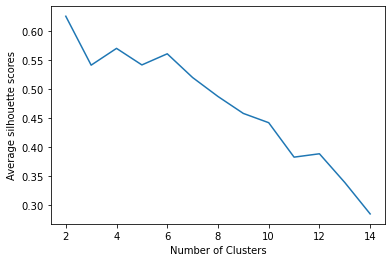

In [378]:
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Average silhouette scores')
plt.show()

In [379]:
#optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
#print('Optimal number of clusters:', optimal_k)

#### Find the optimal value with elbow method

In [380]:
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_reshaped_PCA)
    inertia.append(np.sqrt(kmeans.inertia_))

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

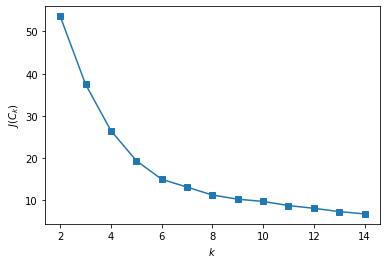

In [381]:
plt.plot(range(2, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering

In [382]:
K=6
k=KMeans(K)

In [383]:
k.fit(df_reshaped_PCA)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

In [384]:
df_reshaped_PCA['cluster_new']=k.fit_predict(df_reshaped_PCA)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [385]:
# df_reshaped_PCA

In [386]:
df_reshaped_PCA.insert(0, 'Participants', list(range(1, 27)))

In [387]:
df_reshaped_PCA.head()

,Participants,0,1,2,3,4,5,6,7,8,...,220,221,222,223,224,225,226,227,228,cluster_new
0,1,-1.200973,-0.886346,-1.158319,-1.150459,-1.176456,-1.160289,-1.170445,-1.179268,-1.164081,...,-1.038762,-1.046313,-1.029054,-1.031080,-1.045960,-1.047326,-1.040388,-1.048012,-1.030369,2
1,2,0.229541,0.204873,0.116297,0.096929,0.098893,0.038059,0.064075,0.063046,-0.021736,...,-0.322432,-0.318425,-0.309409,-0.305827,-0.288190,-0.238425,-0.298112,-0.263252,-0.298674,4
2,3,-0.687501,-0.725967,-0.639223,-0.709477,-0.734788,-0.725696,-0.749672,-0.758911,-0.762046,...,-0.819868,-0.824796,-0.831775,-0.823488,-0.849164,-0.860117,-0.852722,-0.845637,-0.850407,2
3,4,-0.429561,-0.400343,-0.442485,-0.421483,-0.447963,-0.412999,-0.392413,-0.494030,-0.406254,...,-0.442645,-0.434018,-0.455782,-0.436840,-0.453210,-0.425601,-0.446687,-0.428476,-0.461559,4
4,5,-0.681739,-0.661111,-0.685017,-0.663981,-0.653040,-0.658224,-0.688541,-0.682877,-0.663026,...,-0.757805,-0.752707,-0.741076,-0.756877,-0.763937,-0.751012,-0.755420,-0.772476,-0.782282,2


In [388]:
cluster_0 = df_reshaped_PCA[df_reshaped_PCA['cluster_new']==0]
cluster_1 = df_reshaped_PCA[df_reshaped_PCA['cluster_new']==1]
cluster_2 = df_reshaped_PCA[df_reshaped_PCA['cluster_new']==2]
cluster_3 = df_reshaped_PCA[df_reshaped_PCA['cluster_new']==3]
cluster_4 = df_reshaped_PCA[df_reshaped_PCA['cluster_new']==4]
cluster_5 = df_reshaped_PCA[df_reshaped_PCA['cluster_new']==5]

In [389]:
# See the distribution of roles that are in each cluster

cluster_0_roles = []
cluster_1_roles = []
cluster_2_roles = []
cluster_3_roles = []
cluster_4_roles = []
cluster_5_roles = []

for i in cluster_0['Participants'].values:
    cluster_0_roles.append(roles[i])
for i in cluster_1['Participants'].values:
    cluster_1_roles.append(roles[i])
for i in cluster_2['Participants'].values:
    cluster_2_roles.append(roles[i])
for i in cluster_3['Participants'].values:
    cluster_3_roles.append(roles[i])
for i in cluster_4['Participants'].values:
    cluster_4_roles.append(roles[i])
for i in cluster_5['Participants'].values:
    cluster_5_roles.append(roles[i])

print(f'cluster 0: {cluster_0_roles}')
print(f'cluster 1: {cluster_1_roles}')
print(f'cluster 2: {cluster_2_roles}')
print(f'cluster 3: {cluster_3_roles}')
print(f'cluster 4: {cluster_4_roles}')
print(f'cluster 5: {cluster_5_roles}')

cluster 0: [1, 0, 1, 1, 1]
cluster 1: [1, 1]
cluster 2: [0, 1, 0, 0, 0, 0, 0]
cluster 3: [1, 0, 0, 1]
cluster 4: [0, 0, 1, 1, 0, 1]
cluster 5: [1, 0]


In [475]:
1/7

0.14285714285714285

In [469]:
cluster_0['Participants'].values

array([11, 17, 21, 25, 26], dtype=int64)

In [470]:
cluster_1['Participants'].values

array([12, 13], dtype=int64)

In [471]:
cluster_2['Participants'].values

array([ 1,  3,  5,  8, 16, 22, 24], dtype=int64)

In [472]:
cluster_3['Participants'].values

array([ 7,  9, 10, 14], dtype=int64)

In [473]:
cluster_4['Participants'].values

array([ 2,  4, 15, 18, 20, 23], dtype=int64)

In [474]:
cluster_5['Participants'].values

array([ 6, 19], dtype=int64)

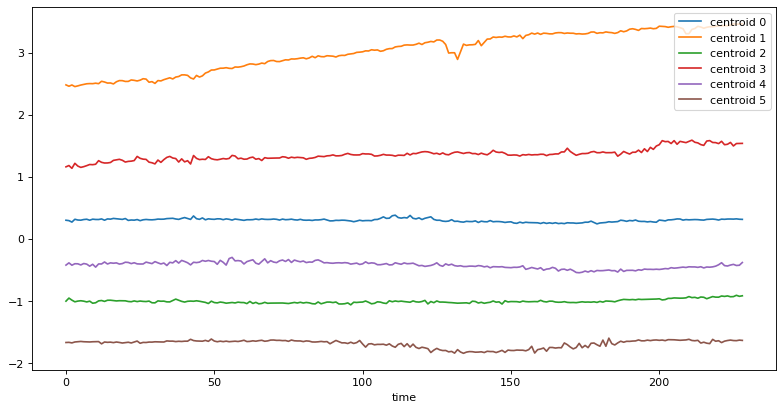

In [396]:
x=range(229)
plt.figure(figsize=(12, 6), dpi=80)

for i, c in enumerate(k.cluster_centers_):
    plt.plot(x, c, label = f'centroid {i}')
plt.legend()
plt.xlabel('time')
plt.show()

In [397]:
#plt.plot(cluster_0[0], cluster_0[1], 'go', label = 'Cluster 1')
#plt.plot(cluster_1[0], cluster_1[1], 'ro', label = 'Cluster 2')
#plt.plot(cluster_2[0], cluster_2[1], 'bo', label = 'Cluster 3')
#plt.plot(cluster_3[0], cluster_3[1], 'ko', label = 'Cluster 4')
#plt.plot(cluster_4[0], cluster_4[1], 'mo', label = 'Cluster 5')
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.legend()
#plt.show()

In [398]:
#ind =  range(0, 26) 
#attributeNames = np.asarray(dt.index[ind])

#X_transformed = X_transformed.to_numpy()


#for att in range(2):
#plt.scatter(X_transformed[0], X_transformed[1], c=X_transformed['cluster_new'])
#plt.text(X_transformed[0], X_transformed[1],attributeNames[att])
#plt.scatter(k.cluster_centers_[:, 0], k.cluster_centers_[:, 1], s=100, marker="x", color='r', label='Cluster Centers')
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.legend()
#plt.show()

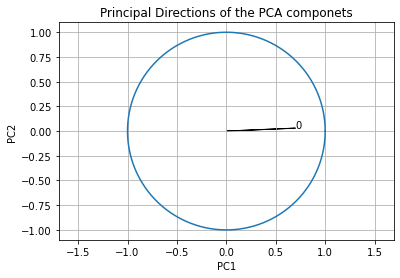

In [399]:
ind =  range(0, 26) 
attributeNames = np.asarray(dt.index[ind])
#%% Attribute coefficients in principal component space
i = 0
j = 1
#f = figure()
#figure(figsize=(20,20))
for att in range(pca.components_.shape[0]):
    plt.arrow(0,0, pca.components_[att,i], pca.components_[att,j])
    plt.text(pca.components_[att,i], pca.components_[att,j], attributeNames[att])
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('PC'+str(i+1))
plt.ylabel('PC'+str(j+1))
plt.grid()
   # Add a unit circle
plt.plot(np.cos(np.arange(0, 2*np.pi, 0.01)), 
np.sin(np.arange(0, 2*np.pi, 0.01)));
plt.title('Principal Directions of the PCA componets')
plt.axis('equal')
#savefig(r'Principan directions 1-2.png')  
plt.show()


## Hierarchical clustering analysis PHASE 1


In [400]:
d_sample = 'euclidean' #See possible values: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
d_group = 'complete' #See possible values (method): https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
N_leafs = 26 #Number of leaf nodes. n=400

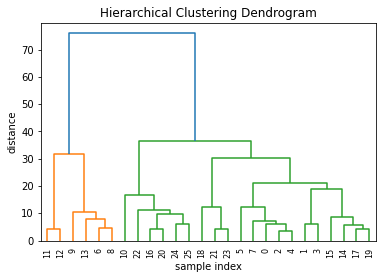

In [401]:
Z = linkage(df_reshaped_PCA, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

den = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

In [402]:
# add the hierarchical cluster to the dataframe for each participant
df_reshaped_PCA['cluster_hierarchy']=cut_tree(Z, n_clusters=6)

cluster_0_ph1_hierarchy = df_reshaped_PCA[df_reshaped_PCA['cluster_hierarchy']==0]
cluster_1_ph1_hierarchy = df_reshaped_PCA[df_reshaped_PCA['cluster_hierarchy']==1]
cluster_2_ph1_hierarchy = df_reshaped_PCA[df_reshaped_PCA['cluster_hierarchy']==2]
cluster_3_ph1_hierarchy = df_reshaped_PCA[df_reshaped_PCA['cluster_hierarchy']==3]
cluster_4_ph1_hierarchy = df_reshaped_PCA[df_reshaped_PCA['cluster_hierarchy']==4]
cluster_5_ph1_hierarchy = df_reshaped_PCA[df_reshaped_PCA['cluster_hierarchy']==5]

In [403]:
# check which participants are in the different clusters
cluster_0_ph1_hierarchy_roles = []
cluster_1_ph1_hierarchy_roles = []
cluster_2_ph1_hierarchy_roles = []
cluster_3_ph1_hierarchy_roles = []
cluster_4_ph1_hierarchy_roles = []
cluster_5_ph1_hierarchy_roles = []

for i in cluster_0_ph1_hierarchy['Participants'].values:
    cluster_0_ph1_hierarchy_roles.append(roles[i])
for i in cluster_1_ph1_hierarchy['Participants'].values:
    cluster_1_ph1_hierarchy_roles.append(roles[i])
for i in cluster_2_ph1_hierarchy['Participants'].values:
    cluster_2_ph1_hierarchy_roles.append(roles[i])
for i in cluster_3_ph1_hierarchy['Participants'].values:
    cluster_3_ph1_hierarchy_roles.append(roles[i])
for i in cluster_4_ph1_hierarchy['Participants'].values:
    cluster_4_ph1_hierarchy_roles.append(roles[i])
for i in cluster_5_ph1_hierarchy['Participants'].values:
    cluster_5_ph1_hierarchy_roles.append(roles[i])

print(f'cluster 0: {cluster_0_ph1_hierarchy_roles}')
print(f'cluster 1: {cluster_1_ph1_hierarchy_roles}')
print(f'cluster 2: {cluster_2_ph1_hierarchy_roles}')
print(f'cluster 3: {cluster_3_ph1_hierarchy_roles}')
print(f'cluster 4: {cluster_4_ph1_hierarchy_roles}')
print(f'cluster 5: {cluster_5_ph1_hierarchy_roles}')

cluster 0: [0, 1, 0, 1, 0]
cluster 1: [0, 0, 1, 0, 1, 0]
cluster 2: [1, 0, 0, 1]
cluster 3: [1, 0, 1, 1, 1, 1]
cluster 4: [1, 1]
cluster 5: [0, 0, 0]


In [487]:
5/6

0.8333333333333334

In [481]:
cluster_0_ph1_hierarchy['Participants'].values

array([1, 3, 5, 6, 8], dtype=int64)

In [482]:
cluster_1_ph1_hierarchy['Participants'].values

array([ 2,  4, 15, 16, 18, 20], dtype=int64)

In [483]:
cluster_2_ph1_hierarchy['Participants'].values

array([ 7,  9, 10, 14], dtype=int64)

In [484]:
cluster_3_ph1_hierarchy['Participants'].values

array([11, 17, 21, 23, 25, 26], dtype=int64)

In [485]:
cluster_4_ph1_hierarchy['Participants'].values

array([12, 13], dtype=int64)

In [486]:
cluster_5_ph1_hierarchy['Participants'].values

array([19, 22, 24], dtype=int64)

## Phase 2

In [404]:
#Creating df's for each TEMP, BVP.....
dt_temp_phase2 = df_dict['TEMP']['phase2'].T
dt_BVP_phase2 = df_dict['BVP']['phase2'].T
dt_EDA_phase2 = df_dict['EDA']['phase2'].T
dt_HR_phase2 = df_dict['HR']['phase2'].T

In [405]:
df_all_2 = [dt_temp_phase2.shape[1],dt_BVP_phase2.shape[1],dt_EDA_phase2.shape[1],dt_HR_phase2.shape[1]]

In [406]:
minvalue = df_all_2[0]
minindex=np.inf
for index, value in enumerate(df_all_2):
    if value < minvalue:
        minvalue=value
        minindex=index

print(minvalue,minindex)

300 3


In [407]:
fir_order = 0 # This determines the cutoff frequency of the filter!!!! min value of each hour at least
downsampling_factor_temp_phase2 = int(np.round(dt_temp_phase2.shape[1]/minvalue))
downsampling_factor_BVP_phase2 = int(np.round(dt_BVP_phase2.shape[1]/minvalue))
downsampling_factor_EDA_phase2 = int(np.round(dt_EDA_phase2.shape[1]/minvalue))
#########
resampled_temp_phase2  = scipy.signal.decimate(dt_temp_phase2 , downsampling_factor_temp_phase2 , ftype='fir', zero_phase=True, n=fir_order)
resampled_BVP_phase2  = scipy.signal.decimate(dt_BVP_phase2 , downsampling_factor_BVP_phase2 , ftype='fir', zero_phase=True, n=fir_order)
resampled_EDA_phase2  = scipy.signal.decimate(dt_EDA_phase2 , downsampling_factor_EDA_phase2 , ftype='fir', zero_phase=True, n=fir_order)

### Merging together the attributes 

In [408]:
temp_phase2_flat = resampled_temp_phase2[:,:300].flatten()
BVP_phase2_flat = resampled_BVP_phase2[:,:300].flatten()
EDA_phase2_flat = resampled_EDA_phase2[:,:300].flatten()
HR_phase2_flat = dt_HR_phase2.to_numpy().flatten()

In [409]:
df_all_flat2 = np.vstack([temp_phase2_flat, BVP_phase2_flat, EDA_phase2_flat, HR_phase2_flat])


In [410]:
dt2 = pd.DataFrame(df_all_flat2.T, columns=['temp','BVP','EDA','HR'])
dt2

,temp,BVP,EDA,HR
0,32.25,-3.40,0.372935,99.05
1,32.29,-13.14,0.361401,98.98
2,32.27,-81.46,0.351148,98.87
3,32.27,49.59,0.363964,98.73
4,32.25,17.36,0.339614,98.62
...,...,...,...,...
7795,34.13,73.76,7.824183,88.78
7796,34.16,5.72,7.830589,88.83
7797,34.15,-224.87,7.804966,88.88
7798,34.16,-232.15,7.767812,88.92


In [411]:
dt2 = (dt2-dt2.mean()) / dt2.std()
dt2.head()

,temp,BVP,EDA,HR
0,-0.339154,-0.040676,-0.663269,1.312154
1,-0.311771,-0.143733,-0.664719,1.306692
2,-0.325462,-0.866620,-0.666007,1.298110
3,-0.325462,0.520006,-0.664397,1.287186
4,-0.339154,0.178984,-0.667457,1.278604


In [412]:
pca2 = PCA(n_components=1)

In [413]:
X_transformed2 = pca2.fit_transform(dt2)

In [414]:
dt_PCA2 = X_transformed2

In [415]:
df_reshaped_PCA2 = pd.DataFrame(np.asarray(dt_PCA2).reshape([26,300]))
df_reshaped_PCA2

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.894731,-0.874088,-0.871277,-0.891567,-0.896340,-0.857838,-0.868801,-0.864051,-0.879438,-0.839178,...,-0.460182,-0.465684,-0.458858,-0.464588,-0.448390,-0.455076,-0.455145,-0.455953,-0.450134,-0.456142
1,-0.103061,-0.095251,-0.108477,-0.112120,-0.099767,-0.100134,-0.028863,-0.156501,-0.100688,-0.100637,...,-0.219920,-0.216874,-0.208462,-0.207241,-0.192277,-0.192684,-0.198977,-0.181516,-0.198564,-0.174703
2,-0.594748,-0.594676,-0.605288,-0.629887,-0.603951,-0.625538,-0.625100,-0.616969,-0.650820,-0.599794,...,-0.881619,-0.900845,-0.901736,-0.915965,-0.915380,-0.931067,-0.921710,-0.954199,-0.956261,-0.960336
3,-0.631467,-0.625276,-0.604512,-0.640211,-0.619044,-0.593907,-0.618346,-0.619391,-0.601112,-0.611997,...,-0.506617,-0.534753,-0.502317,-0.515850,-0.528763,-0.533216,-0.478862,-0.531603,-0.529938,-0.525705
4,-0.583587,-0.586571,-0.563219,-0.585230,-0.584968,-0.590159,-0.578968,-0.577310,-0.573797,-0.587225,...,-0.186713,-0.176718,-0.180869,-0.167131,-0.179324,-0.161847,-0.138943,-0.141714,-0.151903,-0.144481
5,-1.908519,-1.880996,-1.882701,-1.860815,-1.901885,-1.868248,-1.899595,-1.897727,-1.876160,-1.894061,...,-1.875753,-1.876413,-1.883810,-1.886478,-1.887875,-1.892902,-1.897424,-1.912311,-1.901026,-1.907238
6,0.387172,0.360409,0.388755,0.373701,0.360349,0.389871,0.367334,0.373709,0.382002,0.369373,...,0.631301,0.645645,0.673513,0.691209,0.682975,0.676265,0.703716,0.706841,0.706381,0.683994
7,-1.326232,-1.347318,-1.326227,-1.408492,-1.315775,-1.371553,-1.359075,-1.324893,-1.279092,-1.270372,...,-1.330695,-1.307160,-1.221839,-1.215735,-1.099151,-1.309014,-1.206280,-1.134975,-1.061259,-1.171395
8,1.201624,1.192473,1.201546,1.230413,1.221325,1.263704,1.368321,1.351061,1.281266,1.223857,...,1.367922,1.398178,1.383487,1.329182,1.321155,1.372481,1.511874,1.394969,1.358969,1.371325
9,1.268269,1.395987,1.468493,1.491216,1.443467,1.324276,1.327160,1.312855,1.425472,1.307670,...,1.093702,1.267077,1.162550,1.202760,1.100211,1.116017,1.169106,0.982234,1.044181,1.035344


In [416]:
pca2.components_

array([[ 0.69884374, -0.0166123 ,  0.69956722, -0.14814577]])

## Again, the PCA gives high attention to temp and EDA

#### Find the optimal value with silhouette method

In [417]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = np.arange(2,15)
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init=10)
    cluster_labels = clusterer.fit_predict(df_reshaped_PCA2)
    score = silhouette_score(df_reshaped_PCA2, cluster_labels)
    silhouette_scores.append(score)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.p

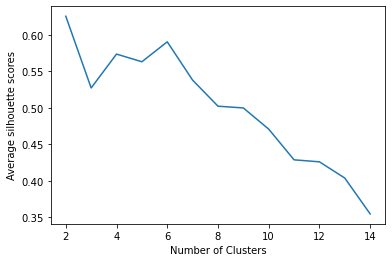

In [418]:
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Average silhouette scores')
plt.show()

#### Find the optimal value with elbow method

In [419]:
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_reshaped_PCA2)
    inertia.append(np.sqrt(kmeans.inertia_))

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

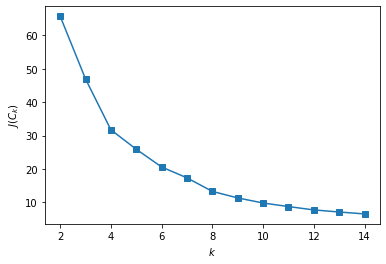

In [420]:
plt.plot(range(2, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [421]:
K=6
k=KMeans(K)

In [422]:
k.fit(df_reshaped_PCA2)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

In [423]:
df_reshaped_PCA2['cluster_new']=k.fit_predict(df_reshaped_PCA2)
df_reshaped_PCA2.head()

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,cluster_new
0,-0.894731,-0.874088,-0.871277,-0.891567,-0.896340,-0.857838,-0.868801,-0.864051,-0.879438,-0.839178,...,-0.465684,-0.458858,-0.464588,-0.448390,-0.455076,-0.455145,-0.455953,-0.450134,-0.456142,2
1,-0.103061,-0.095251,-0.108477,-0.112120,-0.099767,-0.100134,-0.028863,-0.156501,-0.100688,-0.100637,...,-0.216874,-0.208462,-0.207241,-0.192277,-0.192684,-0.198977,-0.181516,-0.198564,-0.174703,2
2,-0.594748,-0.594676,-0.605288,-0.629887,-0.603951,-0.625538,-0.625100,-0.616969,-0.650820,-0.599794,...,-0.900845,-0.901736,-0.915965,-0.915380,-0.931067,-0.921710,-0.954199,-0.956261,-0.960336,2
3,-0.631467,-0.625276,-0.604512,-0.640211,-0.619044,-0.593907,-0.618346,-0.619391,-0.601112,-0.611997,...,-0.534753,-0.502317,-0.515850,-0.528763,-0.533216,-0.478862,-0.531603,-0.529938,-0.525705,2
4,-0.583587,-0.586571,-0.563219,-0.585230,-0.584968,-0.590159,-0.578968,-0.577310,-0.573797,-0.587225,...,-0.176718,-0.180869,-0.167131,-0.179324,-0.161847,-0.138943,-0.141714,-0.151903,-0.144481,2


In [424]:
df_reshaped_PCA2.insert(0, 'Participants', list(range(1, 27)))
df_reshaped_PCA2

,Participants,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,cluster_new
0,1,-0.894731,-0.874088,-0.871277,-0.891567,-0.896340,-0.857838,-0.868801,-0.864051,-0.879438,...,-0.465684,-0.458858,-0.464588,-0.448390,-0.455076,-0.455145,-0.455953,-0.450134,-0.456142,2
1,2,-0.103061,-0.095251,-0.108477,-0.112120,-0.099767,-0.100134,-0.028863,-0.156501,-0.100688,...,-0.216874,-0.208462,-0.207241,-0.192277,-0.192684,-0.198977,-0.181516,-0.198564,-0.174703,2
2,3,-0.594748,-0.594676,-0.605288,-0.629887,-0.603951,-0.625538,-0.625100,-0.616969,-0.650820,...,-0.900845,-0.901736,-0.915965,-0.915380,-0.931067,-0.921710,-0.954199,-0.956261,-0.960336,2
3,4,-0.631467,-0.625276,-0.604512,-0.640211,-0.619044,-0.593907,-0.618346,-0.619391,-0.601112,...,-0.534753,-0.502317,-0.515850,-0.528763,-0.533216,-0.478862,-0.531603,-0.529938,-0.525705,2
4,5,-0.583587,-0.586571,-0.563219,-0.585230,-0.584968,-0.590159,-0.578968,-0.577310,-0.573797,...,-0.176718,-0.180869,-0.167131,-0.179324,-0.161847,-0.138943,-0.141714,-0.151903,-0.144481,2
5,6,-1.908519,-1.880996,-1.882701,-1.860815,-1.901885,-1.868248,-1.899595,-1.897727,-1.876160,...,-1.876413,-1.883810,-1.886478,-1.887875,-1.892902,-1.897424,-1.912311,-1.901026,-1.907238,0
6,7,0.387172,0.360409,0.388755,0.373701,0.360349,0.389871,0.367334,0.373709,0.382002,...,0.645645,0.673513,0.691209,0.682975,0.676265,0.703716,0.706841,0.706381,0.683994,5
7,8,-1.326232,-1.347318,-1.326227,-1.408492,-1.315775,-1.371553,-1.359075,-1.324893,-1.279092,...,-1.307160,-1.221839,-1.215735,-1.099151,-1.309014,-1.206280,-1.134975,-1.061259,-1.171395,0
8,9,1.201624,1.192473,1.201546,1.230413,1.221325,1.263704,1.368321,1.351061,1.281266,...,1.398178,1.383487,1.329182,1.321155,1.372481,1.511874,1.394969,1.358969,1.371325,1
9,10,1.268269,1.395987,1.468493,1.491216,1.443467,1.324276,1.327160,1.312855,1.425472,...,1.267077,1.162550,1.202760,1.100211,1.116017,1.169106,0.982234,1.044181,1.035344,1


In [425]:
cluster_0_ph2 = df_reshaped_PCA2[df_reshaped_PCA2['cluster_new']==0]
cluster_1_ph2 = df_reshaped_PCA2[df_reshaped_PCA2['cluster_new']==1]
cluster_2_ph2 = df_reshaped_PCA2[df_reshaped_PCA2['cluster_new']==2]
cluster_3_ph2 = df_reshaped_PCA2[df_reshaped_PCA2['cluster_new']==3]
cluster_4_ph2 = df_reshaped_PCA2[df_reshaped_PCA2['cluster_new']==4]
cluster_5_ph2 = df_reshaped_PCA2[df_reshaped_PCA2['cluster_new']==5]

In [478]:
# See the distribution of roles that are in each cluster

cluster_0_ph2_roles = []
cluster_1_ph2_roles = []
cluster_2_ph2_roles = []
cluster_3_ph2_roles = []
cluster_4_ph2_roles = []
cluster_5_ph2_roles = []

for i in cluster_0_ph2['Participants'].values:
    cluster_0_ph2_roles.append(roles[i])
for i in cluster_1_ph2['Participants'].values:
    cluster_1_ph2_roles.append(roles[i])
for i in cluster_2_ph2['Participants'].values:
    cluster_2_ph2_roles.append(roles[i])
for i in cluster_3_ph2['Participants'].values:
    cluster_3_ph2_roles.append(roles[i])
for i in cluster_4_ph2['Participants'].values:
    cluster_4_ph2_roles.append(roles[i])
for i in cluster_5_ph2['Participants'].values:
    cluster_5_ph2_roles.append(roles[i])

print(f'cluster 0: {cluster_0_ph2_roles}')
print(f'cluster 1: {cluster_1_ph2_roles}')
print(f'cluster 2: {cluster_2_ph2_roles}')
print(f'cluster 3: {cluster_3_ph2_roles}')
print(f'cluster 4: {cluster_4_ph2_roles}')
print(f'cluster 5: {cluster_5_ph2_roles}')

cluster 0: [1, 0, 0, 0, 0, 0]
cluster 1: [0, 0]
cluster 2: [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
cluster 3: [1]
cluster 4: [1, 1]
cluster 5: [1, 1, 1, 1]


In [480]:
5/11

0.45454545454545453

In [476]:
cluster_0_ph2['Participants'].values

array([ 6,  8, 16, 19, 22, 24], dtype=int64)

In [427]:
cluster_1_ph2['Participants'].values

array([ 9, 10], dtype=int64)

In [428]:
cluster_2_ph2['Participants'].values

array([ 1,  2,  3,  4,  5, 15, 17, 18, 20, 23, 25], dtype=int64)

In [429]:
cluster_3_ph2['Participants'].values

array([13], dtype=int64)

In [430]:
cluster_4_ph2['Participants'].values

array([12, 14], dtype=int64)

In [431]:
cluster_5_ph2['Participants'].values

array([ 7, 11, 21, 26], dtype=int64)

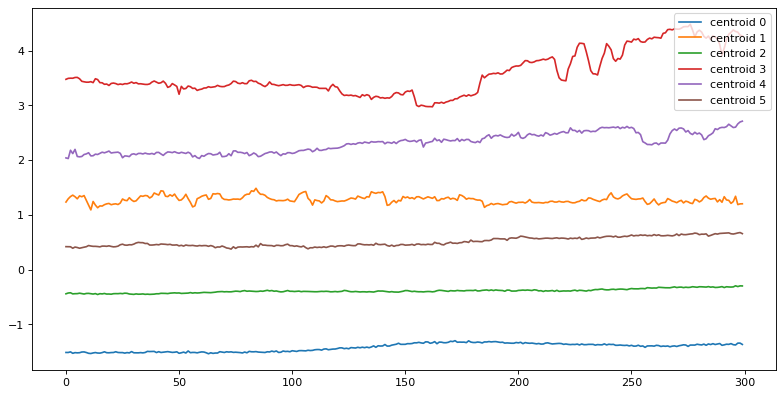

In [432]:
x=range(300)
plt.figure(figsize=(12, 6), dpi=80)

for i, c in enumerate(k.cluster_centers_):
    plt.plot(x, c, label = f'centroid {i}')
plt.legend()
plt.show()

## Hierarchical clustering analysis PHASE 2


In [433]:
d_sample = 'euclidean' #See possible values: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
d_group = 'complete' #See possible values (method): https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
N_leafs = 26 #Number of leaf nodes. n=400

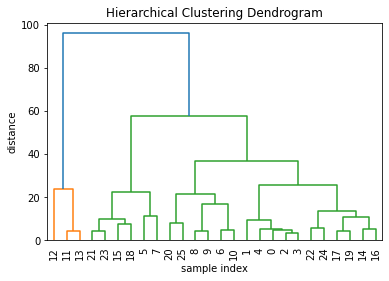

In [434]:
Z = linkage(df_reshaped_PCA2, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

den = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

In [435]:
# add the hierarchical cluster to the dataframe for each participant
df_reshaped_PCA2['cluster_hierarchy']=cut_tree(Z, n_clusters=6)

cluster_0_ph2_hierarchy = df_reshaped_PCA2[df_reshaped_PCA2['cluster_hierarchy']==0]
cluster_1_ph2_hierarchy = df_reshaped_PCA2[df_reshaped_PCA2['cluster_hierarchy']==1]
cluster_2_ph2_hierarchy = df_reshaped_PCA2[df_reshaped_PCA2['cluster_hierarchy']==2]
cluster_3_ph2_hierarchy = df_reshaped_PCA2[df_reshaped_PCA2['cluster_hierarchy']==3]
cluster_4_ph2_hierarchy = df_reshaped_PCA2[df_reshaped_PCA2['cluster_hierarchy']==4]
cluster_5_ph2_hierarchy = df_reshaped_PCA2[df_reshaped_PCA2['cluster_hierarchy']==5]

In [436]:
# check which participants are in the different clusters

cluster_0_ph2_hierarchy_roles = []
cluster_1_ph2_hierarchy_roles = []
cluster_2_ph2_hierarchy_roles = []
cluster_3_ph2_hierarchy_roles = []
cluster_4_ph2_hierarchy_roles = []
cluster_5_ph2_hierarchy_roles = []

for i in cluster_0_ph2_hierarchy['Participants'].values:
    cluster_0_ph2_hierarchy_roles.append(roles[i])
for i in cluster_1_ph2_hierarchy['Participants'].values:
    cluster_1_ph2_hierarchy_roles.append(roles[i])
for i in cluster_2_ph2_hierarchy['Participants'].values:
    cluster_2_ph2_hierarchy_roles.append(roles[i])
for i in cluster_3_ph2_hierarchy['Participants'].values:
    cluster_3_ph2_hierarchy_roles.append(roles[i])
for i in cluster_4_ph2_hierarchy['Participants'].values:
    cluster_4_ph2_hierarchy_roles.append(roles[i])
for i in cluster_5_ph2_hierarchy['Participants'].values:
    cluster_5_ph2_hierarchy_roles.append(roles[i])

print(f'cluster 0: {cluster_0_ph2_hierarchy_roles}')
print(f'cluster 1: {cluster_1_ph2_hierarchy_roles}')
print(f'cluster 2: {cluster_2_ph2_hierarchy_roles}')
print(f'cluster 3: {cluster_3_ph2_hierarchy_roles}')
print(f'cluster 4: {cluster_4_ph2_hierarchy_roles}')
print(f'cluster 5: {cluster_5_ph2_hierarchy_roles}')

cluster 0: [0, 0, 1, 0, 0]
cluster 1: [1, 0, 0, 0, 0, 0]
cluster 2: [1, 0, 0, 1, 1, 1]
cluster 3: [1, 1]
cluster 4: [1]
cluster 5: [1, 0, 1, 0, 1, 1]


In [494]:
1/6

0.16666666666666666

In [488]:
cluster_0_ph2_hierarchy['Participants'].values

array([1, 2, 3, 4, 5], dtype=int64)

In [489]:
cluster_1_ph2_hierarchy['Participants'].values

array([ 6,  8, 16, 19, 22, 24], dtype=int64)

In [490]:
cluster_2_ph2_hierarchy['Participants'].values

array([ 7,  9, 10, 11, 21, 26], dtype=int64)

In [491]:
cluster_3_ph2_hierarchy['Participants'].values

array([12, 14], dtype=int64)

In [492]:
cluster_4_ph2_hierarchy['Participants'].values

array([13], dtype=int64)

In [493]:
cluster_5_ph2_hierarchy['Participants'].values

array([15, 17, 18, 20, 23, 25], dtype=int64)

([<matplotlib.patches.Wedge at 0x1bebb48f990>,
 [Text(-0.8899187180267095, 0.6465637441936395, ''),
  Text(0.8899187482945414, -0.6465637025335375, '')])

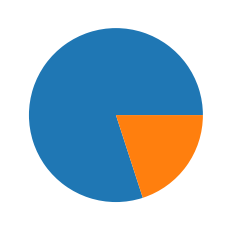

In [437]:
plt.pie([4,1])

## Phase 3

In [438]:
#Creating df's for each TEMP, BVP.....
dt_temp_phase3 = df_dict['TEMP']['phase3'].T
dt_BVP_phase3 = df_dict['BVP']['phase3'].T
dt_EDA_phase3 = df_dict['EDA']['phase3'].T
dt_HR_phase3 = df_dict['HR']['phase3'].T

In [439]:
df_all_3 = [dt_temp_phase3.shape[1],dt_BVP_phase3.shape[1],dt_EDA_phase3.shape[1],dt_HR_phase3.shape[1]]

In [440]:
minvalue = df_all_3[0]
minindex=np.inf
for index, value in enumerate(df_all_3):
    if value < minvalue:
        minvalue=value
        minindex=index

print(minvalue,minindex)

280 3


In [441]:
fir_order = 0 # This determines the cutoff frequency of the filter!!!! min value of each hour at least
downsampling_factor_temp_phase3 = int(np.round(dt_temp_phase3.shape[1]/minvalue))
downsampling_factor_BVP_phase3 = int(np.round(dt_BVP_phase3.shape[1]/minvalue))
downsampling_factor_EDA_phase3 = int(np.round(dt_EDA_phase3.shape[1]/minvalue))
#########
resampled_temp_phase3  = scipy.signal.decimate(dt_temp_phase3 , downsampling_factor_temp_phase3 , ftype='fir', zero_phase=True, n=fir_order)
resampled_BVP_phase3  = scipy.signal.decimate(dt_BVP_phase3 , downsampling_factor_BVP_phase3 , ftype='fir', zero_phase=True, n=fir_order)
resampled_EDA_phase3  = scipy.signal.decimate(dt_EDA_phase3 , downsampling_factor_EDA_phase3 , ftype='fir', zero_phase=True, n=fir_order)

### Merging together the attributes 

In [442]:
temp_phase3_flat = resampled_temp_phase3[:,:300].flatten()
BVP_phase3_flat = resampled_BVP_phase3[:,:300].flatten()
EDA_phase3_flat = resampled_EDA_phase3[:,:300].flatten()
HR_phase3_flat = dt_HR_phase3.to_numpy().flatten()

In [443]:
df_all_flat3 = np.vstack([temp_phase3_flat, BVP_phase3_flat, EDA_phase3_flat, HR_phase3_flat])


In [444]:
dt3 = pd.DataFrame(df_all_flat3.T, columns=['temp','BVP','EDA','HR'])
dt3

,temp,BVP,EDA,HR
0,32.97,-9.10,0.439576,84.42
1,32.95,-110.23,0.420353,84.42
2,32.95,18.85,0.426760,84.42
3,32.95,24.25,0.990915,84.43
4,32.95,35.91,0.576970,84.68
...,...,...,...,...
7275,34.23,24.63,6.231552,86.97
7276,34.25,-88.91,6.211053,86.93
7277,34.23,23.14,6.194397,86.92
7278,34.21,-23.79,6.177742,86.87


In [445]:
dt3 = (dt3-dt3.mean()) / dt3.std()
dt3.head()

,temp,BVP,EDA,HR
0,0.113370,-0.080482,-0.677394,0.284818
1,0.101014,-0.946487,-0.679239,0.284818
2,0.101014,0.158862,-0.678624,0.284818
3,0.101014,0.205103,-0.624479,0.285553
4,0.101014,0.304951,-0.664208,0.303932


In [446]:
pca3 = PCA(n_components=1)

In [447]:
X_transformed3 = pca3.fit_transform(dt3)

In [448]:
dt_PCA3 = X_transformed3

In [449]:
df_reshaped_PCA3 = pd.DataFrame(np.asarray(dt_PCA3).reshape([26,280]))
df_reshaped_PCA3

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,-0.466381,-0.443461,-0.484466,-0.449169,-0.485358,-0.534374,-0.492009,-0.591187,-0.570805,-0.638894,...,-0.558354,-0.552581,-0.559746,-0.564503,-0.562101,-0.553025,-0.547039,-0.564793,-0.566827,-0.563186
1,-0.172667,-0.174592,-0.060349,-0.162053,-0.180194,-0.173954,-0.160418,-0.176765,-0.157618,-0.041737,...,-0.137793,-0.135918,-0.141983,-0.132422,-0.123236,-0.129642,-0.128752,-0.126709,-0.117437,-0.125538
2,-0.990857,-1.001413,-1.058959,-1.017370,-0.936600,-0.977804,-0.993271,-0.952392,-0.987678,-0.997183,...,-0.400074,-0.619952,-0.491718,-0.593851,-0.493420,-0.553691,-0.373106,-0.381900,-0.417195,-0.419408
3,-0.523074,-0.553480,-0.527197,-0.502193,-0.513797,-0.515988,-0.547055,-0.521803,-0.506080,-0.510647,...,-0.532146,-0.537834,-0.540387,-0.549906,-0.538071,-0.538309,-0.514092,-0.534854,-0.524613,-0.524376
4,0.151847,0.135432,0.139250,0.194608,0.132450,0.117224,0.106404,0.101423,0.113523,0.127173,...,0.316785,0.303763,0.323464,0.313492,0.335139,0.357276,0.340843,0.334287,0.347978,0.346680
5,-2.392399,-2.356406,-2.431516,-2.428557,-2.408401,-2.426949,-2.431260,-2.421567,-2.499853,-2.428197,...,-1.667539,-1.656839,-1.665461,-1.679166,-1.676506,-1.675684,-1.689207,-1.659382,-1.678836,-1.699806
6,0.459431,0.526288,0.506321,0.518973,0.506931,0.507809,0.538698,0.478551,0.483424,0.502642,...,0.961008,0.945383,0.954666,0.941460,0.935864,0.937125,0.946142,0.943825,0.916220,0.904388
7,-0.905679,-0.978905,-0.868140,-0.903987,-1.020245,-0.887711,-0.977821,-0.896526,-0.916321,-0.993043,...,-1.138490,-1.149000,-1.146069,-1.136180,-1.141403,-1.134793,-1.133044,-1.149657,-1.124510,-1.127936
8,1.115097,1.162404,1.145409,1.085928,1.040742,1.063888,1.080480,1.093501,1.123641,1.094085,...,1.095203,1.102910,1.078682,1.095922,1.124524,1.138216,1.108724,1.115903,1.119075,1.125256
9,0.931884,0.938842,0.976958,0.898494,0.881665,0.977841,0.901712,1.003898,0.989365,0.990236,...,1.356128,1.345455,1.346495,1.334556,1.343525,1.353479,1.384076,1.359353,1.343941,1.323382


In [450]:
pca3.components_

array([[ 0.66925136, -0.03747936,  0.6877019 , -0.278862  ]])

## Again, the PCA gives high attention to temp and EDA

#### Find the optimal value with silhouette method

In [451]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = np.arange(2,15)
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init=10)
    cluster_labels = clusterer.fit_predict(df_reshaped_PCA3)
    score = silhouette_score(df_reshaped_PCA3, cluster_labels)
    silhouette_scores.append(score)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.p

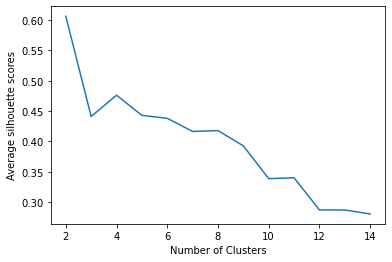

In [452]:
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Average silhouette scores')
plt.show()

#### Find the optimal value with elbow method

In [453]:
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_reshaped_PCA3)
    inertia.append(np.sqrt(kmeans.inertia_))

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

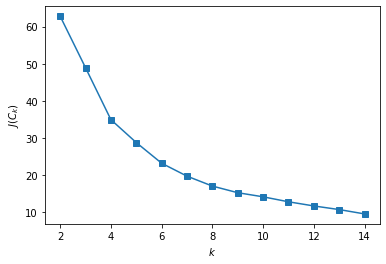

In [454]:
plt.plot(range(2, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [455]:
K=6
k=KMeans(K)

In [456]:
k.fit(df_reshaped_PCA3)

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

In [457]:
df_reshaped_PCA3['cluster_new']=k.fit_predict(df_reshaped_PCA3)
df_reshaped_PCA3.head()

c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\maxsp\anaconda3\envs\course02582\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,cluster_new
0,-0.466381,-0.443461,-0.484466,-0.449169,-0.485358,-0.534374,-0.492009,-0.591187,-0.570805,-0.638894,...,-0.552581,-0.559746,-0.564503,-0.562101,-0.553025,-0.547039,-0.564793,-0.566827,-0.563186,4
1,-0.172667,-0.174592,-0.060349,-0.162053,-0.180194,-0.173954,-0.160418,-0.176765,-0.157618,-0.041737,...,-0.135918,-0.141983,-0.132422,-0.123236,-0.129642,-0.128752,-0.126709,-0.117437,-0.125538,4
2,-0.990857,-1.001413,-1.058959,-1.017370,-0.936600,-0.977804,-0.993271,-0.952392,-0.987678,-0.997183,...,-0.619952,-0.491718,-0.593851,-0.493420,-0.553691,-0.373106,-0.381900,-0.417195,-0.419408,4
3,-0.523074,-0.553480,-0.527197,-0.502193,-0.513797,-0.515988,-0.547055,-0.521803,-0.506080,-0.510647,...,-0.537834,-0.540387,-0.549906,-0.538071,-0.538309,-0.514092,-0.534854,-0.524613,-0.524376,4
4,0.151847,0.135432,0.139250,0.194608,0.132450,0.117224,0.106404,0.101423,0.113523,0.127173,...,0.303763,0.323464,0.313492,0.335139,0.357276,0.340843,0.334287,0.347978,0.346680,0


In [458]:
df_reshaped_PCA3.insert(0, 'Participants', list(range(1, 27)))
df_reshaped_PCA3

,Participants,0,1,2,3,4,5,6,7,8,...,271,272,273,274,275,276,277,278,279,cluster_new
0,1,-0.466381,-0.443461,-0.484466,-0.449169,-0.485358,-0.534374,-0.492009,-0.591187,-0.570805,...,-0.552581,-0.559746,-0.564503,-0.562101,-0.553025,-0.547039,-0.564793,-0.566827,-0.563186,4
1,2,-0.172667,-0.174592,-0.060349,-0.162053,-0.180194,-0.173954,-0.160418,-0.176765,-0.157618,...,-0.135918,-0.141983,-0.132422,-0.123236,-0.129642,-0.128752,-0.126709,-0.117437,-0.125538,4
2,3,-0.990857,-1.001413,-1.058959,-1.017370,-0.936600,-0.977804,-0.993271,-0.952392,-0.987678,...,-0.619952,-0.491718,-0.593851,-0.493420,-0.553691,-0.373106,-0.381900,-0.417195,-0.419408,4
3,4,-0.523074,-0.553480,-0.527197,-0.502193,-0.513797,-0.515988,-0.547055,-0.521803,-0.506080,...,-0.537834,-0.540387,-0.549906,-0.538071,-0.538309,-0.514092,-0.534854,-0.524613,-0.524376,4
4,5,0.151847,0.135432,0.139250,0.194608,0.132450,0.117224,0.106404,0.101423,0.113523,...,0.303763,0.323464,0.313492,0.335139,0.357276,0.340843,0.334287,0.347978,0.346680,0
5,6,-2.392399,-2.356406,-2.431516,-2.428557,-2.408401,-2.426949,-2.431260,-2.421567,-2.499853,...,-1.656839,-1.665461,-1.679166,-1.676506,-1.675684,-1.689207,-1.659382,-1.678836,-1.699806,2
6,7,0.459431,0.526288,0.506321,0.518973,0.506931,0.507809,0.538698,0.478551,0.483424,...,0.945383,0.954666,0.941460,0.935864,0.937125,0.946142,0.943825,0.916220,0.904388,5
7,8,-0.905679,-0.978905,-0.868140,-0.903987,-1.020245,-0.887711,-0.977821,-0.896526,-0.916321,...,-1.149000,-1.146069,-1.136180,-1.141403,-1.134793,-1.133044,-1.149657,-1.124510,-1.127936,4
8,9,1.115097,1.162404,1.145409,1.085928,1.040742,1.063888,1.080480,1.093501,1.123641,...,1.102910,1.078682,1.095922,1.124524,1.138216,1.108724,1.115903,1.119075,1.125256,5
9,10,0.931884,0.938842,0.976958,0.898494,0.881665,0.977841,0.901712,1.003898,0.989365,...,1.345455,1.346495,1.334556,1.343525,1.353479,1.384076,1.359353,1.343941,1.323382,5


In [459]:
cluster_0_ph3 = df_reshaped_PCA3[df_reshaped_PCA3['cluster_new']==0]
cluster_1_ph3 = df_reshaped_PCA3[df_reshaped_PCA3['cluster_new']==1]
cluster_2_ph3 = df_reshaped_PCA3[df_reshaped_PCA3['cluster_new']==2]
cluster_3_ph3 = df_reshaped_PCA3[df_reshaped_PCA3['cluster_new']==3]
cluster_4_ph3 = df_reshaped_PCA3[df_reshaped_PCA3['cluster_new']==4]
cluster_5_ph3 = df_reshaped_PCA3[df_reshaped_PCA3['cluster_new']==5]

In [460]:
# See the distribution of roles that are in each cluster

cluster_0_ph3_roles = []
cluster_1_ph3_roles = []
cluster_2_ph3_roles = []
cluster_3_ph3_roles = []
cluster_4_ph3_roles = []
cluster_5_ph3_roles = []

for i in cluster_0_ph3['Participants'].values:
    cluster_0_ph3_roles.append(roles[i])
for i in cluster_1_ph3['Participants'].values:
    cluster_1_ph3_roles.append(roles[i])
for i in cluster_2_ph3['Participants'].values:
    cluster_2_ph3_roles.append(roles[i])
for i in cluster_3_ph3['Participants'].values:
    cluster_3_ph3_roles.append(roles[i])
for i in cluster_4_ph3['Participants'].values:
    cluster_4_ph3_roles.append(roles[i])
for i in cluster_5_ph3['Participants'].values:
    cluster_5_ph3_roles.append(roles[i])

print(f'cluster 0: {cluster_0_ph3_roles}')
print(f'cluster 1: {cluster_1_ph3_roles}')
print(f'cluster 2: {cluster_2_ph3_roles}')
print(f'cluster 3: {cluster_3_ph3_roles}')
print(f'cluster 4: {cluster_4_ph3_roles}')
print(f'cluster 5: {cluster_5_ph3_roles}')

cluster 0: [0, 1, 0, 0, 1, 1, 1, 1]
cluster 1: [1, 1]
cluster 2: [1, 0, 0]
cluster 3: [1]
cluster 4: [0, 0, 1, 0, 0, 0, 1, 0]
cluster 5: [1, 0, 0, 1]


In [461]:
cluster_0_ph3['Participants'].values

array([ 5, 15, 17, 20, 21, 23, 25, 26], dtype=int64)

In [462]:
cluster_1_ph3['Participants'].values

array([12, 14], dtype=int64)

In [463]:
cluster_2_ph3['Participants'].values

array([ 6, 19, 24], dtype=int64)

In [464]:
cluster_3_ph3['Participants'].values

array([13], dtype=int64)

In [465]:
cluster_4_ph3['Participants'].values

array([ 1,  2,  3,  4,  8, 16, 18, 22], dtype=int64)

In [466]:
cluster_5_ph3['Participants'].values

array([ 7,  9, 10, 11], dtype=int64)

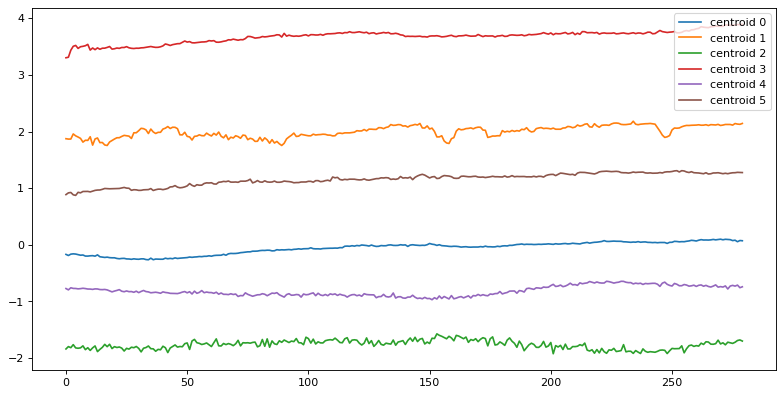

In [467]:
x=range(280)
plt.figure(figsize=(12, 6), dpi=80)

for i, c in enumerate(k.cluster_centers_):
    plt.plot(x, c, label = f'centroid {i}')
plt.legend()
plt.show()

## Hierarchical clustering analysis PHASE 2


In [327]:
d_sample = 'euclidean' #See possible values: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
d_group = 'complete' #See possible values (method): https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
N_leafs = 26 #Number of leaf nodes. n=400

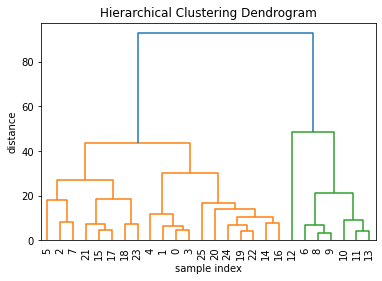

In [328]:
Z = linkage(df_reshaped_PCA3, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

den = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

In [329]:
# add the hierarchical cluster to the dataframe for each participant
df_reshaped_PCA3['cluster_hierarchy']=cut_tree(Z, n_clusters=6)

cluster_0_ph3_hierarchy = df_reshaped_PCA3[df_reshaped_PCA3['cluster_hierarchy']==0]
cluster_1_ph3_hierarchy = df_reshaped_PCA3[df_reshaped_PCA3['cluster_hierarchy']==1]
cluster_2_ph3_hierarchy = df_reshaped_PCA3[df_reshaped_PCA3['cluster_hierarchy']==2]
cluster_3_ph3_hierarchy = df_reshaped_PCA3[df_reshaped_PCA3['cluster_hierarchy']==3]
cluster_4_ph3_hierarchy = df_reshaped_PCA3[df_reshaped_PCA3['cluster_hierarchy']==4]
cluster_5_ph3_hierarchy = df_reshaped_PCA3[df_reshaped_PCA3['cluster_hierarchy']==5]

In [330]:
# check which participants are in the different clusters

cluster_0_ph3_hierarchy_roles = []
cluster_1_ph3_hierarchy_roles = []
cluster_2_ph3_hierarchy_roles = []
cluster_3_ph3_hierarchy_roles = []
cluster_4_ph3_hierarchy_roles = []
cluster_5_ph3_hierarchy_roles = []

for i in cluster_0_ph3_hierarchy['Participants'].values:
    cluster_0_ph3_hierarchy_roles.append(roles[i])
for i in cluster_1_ph3_hierarchy['Participants'].values:
    cluster_1_ph3_hierarchy_roles.append(roles[i])
for i in cluster_2_ph3_hierarchy['Participants'].values:
    cluster_2_ph3_hierarchy_roles.append(roles[i])
for i in cluster_3_ph3_hierarchy['Participants'].values:
    cluster_3_ph3_hierarchy_roles.append(roles[i])
for i in cluster_4_ph3_hierarchy['Participants'].values:
    cluster_4_ph3_hierarchy_roles.append(roles[i])
for i in cluster_5_ph3_hierarchy['Participants'].values:
    cluster_5_ph3_hierarchy_roles.append(roles[i])

print(f'cluster 0: {cluster_0_ph3_hierarchy_roles}')
print(f'cluster 1: {cluster_1_ph3_hierarchy_roles}')
print(f'cluster 2: {cluster_2_ph3_hierarchy_roles}')
print(f'cluster 3: {cluster_3_ph3_hierarchy_roles}')
print(f'cluster 4: {cluster_4_ph3_hierarchy_roles}')
print(f'cluster 5: {cluster_5_ph3_hierarchy_roles}')

cluster 0: [0, 0, 0, 0]
cluster 1: [1, 1, 0]
cluster 2: [1, 0, 0, 1, 1, 1]
cluster 3: [1]
cluster 4: [1, 0, 0, 1, 1, 1, 1]
cluster 5: [0, 1, 0, 0, 0]
